# <center> Feature generation

In [1]:
%store -r __ipy
%store -r __da

In [2]:
__ipy

Helper ipython script loaded


In [3]:
__da

Basic Data Analysis tools was loaded


In [4]:
# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error 
from tqdm.auto import tqdm
from knockknock import telegram_sender
from hyperopt.pyll import scope
from sklearn.model_selection import *
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import math

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import lightgbm as lgb
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
import numpy as np
import pandas as pd
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters ,ComprehensiveFCParameters
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
import timeit
import seaborn as sns
import sys
import time
from tqdm import tqdm
import warnings
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

from sklearn.model_selection import *
import lightgbm as lgb

root = 'data/'
KEY = ['building_id', 'meter', 'site_id']
KEY_NAME = 'building_id__meter__key'

In [ ]:
train_df = pd.read_pickle(root + 'train_df.pkl')
test_df = pd.read_pickle(root + 'test_df.pkl')
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [6]:
%%time

train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

le = LabelEncoder()
train_df['primary_use'] = train_df['primary_use'].astype(str)
train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

test_df['primary_use'] = test_df['primary_use'].astype(str)
test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 


train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

def to_key(train_df):
    le_key = LabelEncoder()
    train_df[KEY_NAME] = train_df[KEY].progress_apply(\
        lambda x: str(x['building_id']) + "_" + str(x['meter']) + "_" +   str(x['site_id']), axis=1)
    
    le_key.fit(train_df[KEY_NAME])
    train_df[KEY_NAME] = le_key.transform(train_df[KEY_NAME])
    train_df[KEY_NAME] = train_df[KEY_NAME].astype(np.int32)
    return train_df

train_df = to_key(train_df)
test_df = to_key(test_df)

train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

Wall time: 1min 3s


In [10]:
train_df = pd.read_pickle(root + "train_features.pkl")
full_train_df = train_df[feat_cols]
target = train_df['meter_reading_log1p']

In [11]:
feat_cols = ['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key']

categoricals =  ['building_id', 'meter','site_id',
       'primary_use', 'year_built', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key']

In [12]:
train_df = train_df.reset_index(drop=True)
full_train_df = train_df[feat_cols]
target = train_df['meter_reading_log1p']

## TSFresh

In [102]:
settings={
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,

 'number_peaks': [{'n': 1}, {'n': 5}],
 'ar_coefficient': [{'coeff': 0, 'k': 10}]
}

**Test features**

In [103]:
n_samples = 100000
train_t = train_df[:n_samples]

def tsfresh_time(sett, column_sort, column_value):
    for f, param in tqdm(sett.items()):
        res.loc[f, "feature"] = f
        fc_dict = {f:param}
        t = timeit.timeit(lambda : extract_features(train_t, 
                         column_id=KEY_NAME,
                         column_sort=column_sort,
                         column_value=column_value,
                         n_jobs=12, 
                         default_fc_parameters=fc_dict, 
                         disable_progressbar=True), 
                         number=3)
        
        res.loc[f, "t_abs"] = t
    return res

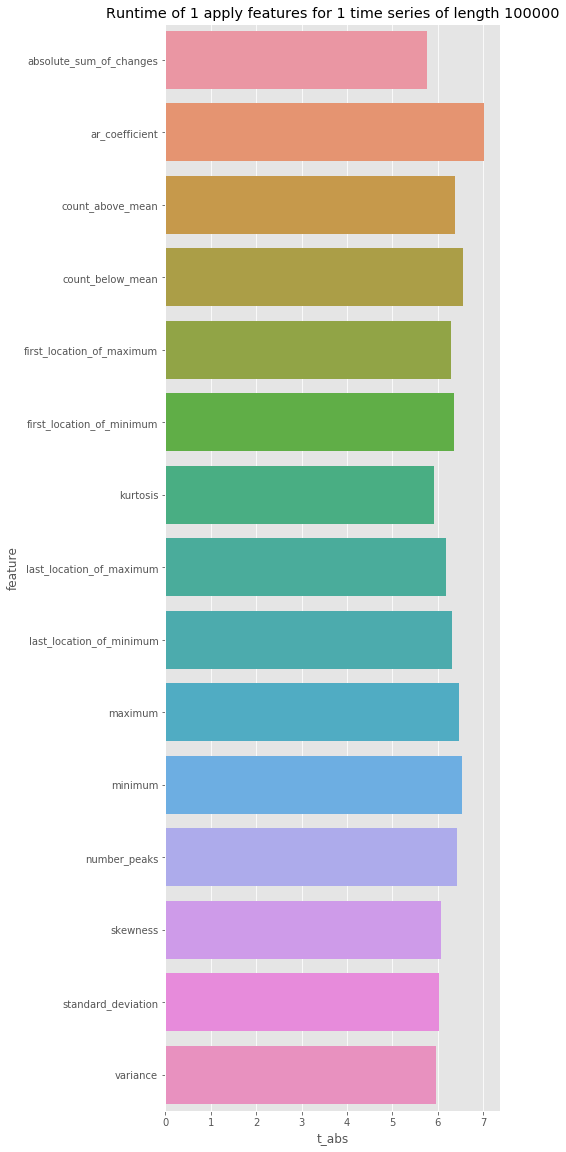

In [104]:
res=pd.DataFrame()
res=tsfresh_time(settings, 'timestamp', 'meter_reading')
res["feature"] = res.feature.astype(str)
res = res.sort_values(by="feature")

plt.figure(figsize=(6, 20))
sns.barplot(y="feature", x="t_abs", data=res)
plt.title("Runtime of 1 apply features for 1 time series of length %d"  % n_samples)
plt.show()

In [15]:
train_df = train_df.reset_index(drop=True)
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key',
       'meter_reading_log1p'],
      dtype='object')

In [118]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
tscv = KFold(n_splits=5)

start = time.time()

X = train_df[:n_samples]

def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X


X_filtered = pd.DataFrame()

for i, (train_index, test_index) in tqdm(enumerate(tscv.split(X))):
    X_train = X.loc[train_index] 
    features = ts_features(X_train, 'hour_datetime', 'meter_reading',  settings)
    X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
#X_filtered=X_filtered.reset_index().drop(['id'], axis=1)

print(X_filtered.shape)

end = time.time()
print("Time",end - start)




0it [00:00, ?it/s]

(2203, 146)
(2203, 146)





1it [00:11, 11.75s/it]

(2203, 146)
(2204, 292)





2it [00:23, 11.76s/it]

(2204, 146)
(2204, 438)





3it [00:35, 11.74s/it]

(2204, 146)
(2204, 584)





4it [00:47, 11.77s/it]

(2203, 146)
(2204, 730)





5it [00:58, 11.77s/it]


(2204, 730)
Time 58.85410237312317


In [16]:
time_cols = ['month_datetime', 'weekofyear_datetime',
             'dayofyear_datetime', 'hour_datetime', 
             'day_week', 'day_month_datetime',
             'week_month_datetime']

In [29]:
def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X, y_col_name, time_cols, k_folds=5):
    tscv = KFold(n_splits=k_folds)
    
    start = time.time()

    X_filtered = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train = X.loc[train_index, :]
        print(np.isnan(X_train[KEY_NAME].values))
        for time_col in time_cols:         
            features = ts_features(X_train, time_col, y_col_name,  settings)
            
            for col in features.columns:
                features[col] = features[col].astype(np.float16)
            
            X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
    X_filtered = X_filtered.replace([np.inf, -np.inf, np.nan], 0)
    impute(X_filtered)
    
    end = time.time()
    print("Time",end - start)
    
    return X_filtered


def generate_and_merge(X_train, X_test=None):
    features = generate_ts_features(X_train, 'meter_reading_log1p', ['hour_datetime'], k_folds=6)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if X_test:
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test

In [48]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit

start = time.time()

X = train_df[:n_samples]
features = generate_ts_features(X, 'meter_reading_log1p', ['hour_datetime'], k_folds=6)

end = time.time()
print("Time",end - start)

[False False False ... False False False]


c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\site-packages\pandas\core\indexes\base.py:493: ResourceWarning:

unclosed <ssl.SSLSocket fd=3484, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.23.22.15', 59191), raddr=('149.154.167.220', 443)>

c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\site-packages\pandas\core\indexes\base.py:493: ResourceWarning:

unclosed <ssl.SSLSocket fd=3744, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.23.22.15', 59195), raddr=('149.154.167.220', 443)>



[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
Time 23.725146055221558
Time 23.729153871536255


In [29]:
feat_cols = ['building_id', 'meter', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', KEY_NAME]

categoricals =  ['building_id', 'meter','site_id',
       'primary_use', 'year_built', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', KEY_NAME]

In [76]:
full_train_df = train_df.drop('timestamp', axis=1)
target = train_df['meter_reading']

In [37]:
from tqdm.auto import tqdm
from knockknock import telegram_sender


def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X, y_col_name, time_cols, k_folds=5):
    tscv = KFold(n_splits=k_folds)
    
    start = time.time()

    X_filtered = pd.DataFrame()

    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train = X.loc[train_index, :]
        
        for time_col in time_cols:
            print(X_train.head())
            features = ts_features(X_train, time_col, y_col_name,  settings)
            
            for col in features.columns:
                features[col] = features[col].astype(np.float16)
            
            X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
    X_filtered = X_filtered.replace([np.inf, -np.inf, np.nan], 0)
    impute(X_filtered)
    
    end = time.time()
    print("Time",end - start)
    
    return X_filtered


def generate_and_merge(X_train, X_test=None):
    features = generate_ts_features(X_train, 'meter_reading', ['hour_datetime'], k_folds=6)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if X_test != None:
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test

folds = 6
@telegram_sender(token=TELEGRAM_API_KEY, chat_id=CHAT_ID)
def lgbm_cross_validation(params):
    seed = 42
    
    kf = KFold(n_splits=folds)
    total_loss = []
    
    for train_index, val_index in kf.split(full_train_df):
        
        train_X = full_train_df.loc[train_index, [*feat_cols, 'meter_reading']].reset_index(drop=True)
        val_X = full_train_df.loc[val_index, feat_cols].reset_index(drop=True)
        train_y = target.iloc[train_index]
        val_y = target.iloc[val_index]
        
        print(train_X[KEY_NAME].head())

        ###
        
        train_X, val_X = generate_and_merge(train_X, val_X)
        ###
        train_X = train_X.drop('meter_reading', axis=1, inplace=True)
        ####
        
        ####
        
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
        lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
        lgbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds=100,
                    verbose_eval = 0)
        
        pred_y = lgbm.predict(val_X)
        mse = np.sqrt(mean_squared_error((val_y), (pred_y)))
        total_loss.append(mse)

    return {'loss': np.mean(total_loss), 'status': STATUS_OK, 'params': params }

def optimize_lgbm(max_evals=1000):
    space = {
        'metric': {'rmse'},
        'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 0, 6, 1)),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    }
    
    trials = Trials()
    best = fmin(fn=lgbm_cross_validation,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                verbose= 1)

    # find the trial with lowest loss value. this is what we consider the best one
    idx = np.argmin(trials.losses())
    print(idx)

    print(trials.trials[idx])
    # these should be the training parameters to use to achieve the best score in best trial
    params = trials.trials[idx]["result"]["params"]
    
    print(params)
    return params

In [38]:
##%%notify -m "Hyperopt execution was finished"

hp_params = optimize_lgbm(2)
hp_params

0    2124                                                                                                                                                                                                                                                                  
1    2125
2    2126
3    2127
4    2128
Name: building_id__meter__key, dtype: int32
         building_id  meter  site_id  primary_use  square_feet  year_built  \                                                                                                                                                                                              
2759707          922      0        9            0       147205        -999   
2759708          922      1        9            0       147205        -999   
2759709          922      2        9            0       147205        -999   
2759710          923      0        9            0        24992        -999   
2759711          923      1        9            0        24992      

[5 rows x 24 columns]
   building_id  meter  site_id  primary_use  square_feet  year_built  \                                                                                                                                                                                                    
0          904      0        9            0        29961        -999   
1          905      0        9            4        39648        -999   
2          905      1        9            4        39648        -999   
3          905      2        9            4        39648        -999   
4          906      0        9            4        39649        -999   

   floor_count  air_temperature  cloud_coverage  dew_temperature  \
0         -999            14.40               0            12.20   
1         -999            14.40               0            12.20   
2         -999            14.40               0            12.20   
3         -999            14.40               0            12.20   
4        

MemoryError: Unable to allocate array with shape (744, 16558238) and data type float16

In [36]:
import gc
gc.collect()

20